In [13]:
import array
import os
#import commands
import time
import math
import sys
import string
import fileinput
import re
import subprocess
import traceback
from typing import List, Tuple, Union

In [14]:
def find_float(arr0, st0, fl0):
    for line in arr0:
        find = re.search(st0, line)
        if (find):
            t = re.search('-*[0-9]*\.*[0-9]+', line)
            if t is not None:
                fl0 = float(t.group())
                return 1, fl0
    return -1, fl0

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1538877/1383287748.py:5: SyntaxWarning: invalid escape sequence '\.'
  t = re.search('-*[0-9]*\.*[0-9]+', line)


In [15]:
def search_best(arr0, st0, st1, ab, minmax, fl0):
    if minmax == "min":
        fl0 = 1e+20
    else:
        fl0 = -1e+20
    for line in arr0:
        find = re.search(st0, line)
        if (find):
            find = re.search(st1, line)
            if (find):
                split_line = line.split(' ')
                st1_split = st1.split(' ')
                words = len(st1_split)
                i = 0
                for word in split_line:
                    if word == st1_split[i]:
                        i += 1
                    if i == words:
                        if ab == "a":
                            ind = split_line.index(word) + 2
                            fl1 = split_line[ind]
                            if "inf" in fl1:
                                fl1 = 1e+20 if minmax == "min" else -1e+20
                            else:
                                fl1 = float(fl1)
                            if minmax == "min" and fl1 < fl0:
                                fl0 = fl1
                            elif minmax == "max" and fl1 > fl0:
                                fl0 = fl1
                        else:
                            ind = split_line.index(word) - words
                            fl1 = float(split_line[ind])
                            if minmax == "min" and fl1 < fl0:
                                fl0 = fl1
                            elif minmax == "max"  and fl1 > fl0:
                                fl0 = fl1
                        break
    return 1, fl0

In [16]:
def InstanceOutput(instance,output):
    file_data = output.read().split('\n')
    time = 0
    find, time = find_float(file_data, "MultiStart: wall clock time used", time)
    if find < 0:
        time = 3600
        
    status = ""
    for line in file_data:
        find = re.search("MultiStart: status of branch-and-bound:", line)
        if (find):
                status = line.partition("MultiStart: status of branch-and-bound: ")[2]
                if status == "Optimal solution found":
                    status = "OPT"
                elif status == "Reached time limit":
                    status = "TL"
                elif status == "Detected infeasibility":
                    status = "INFEAS"
                else:
                    print(instance, "THIS SHOULD NOT HAPPEN")
                    sys.exit(0)
    ##UB
    ub = 0
    if status == "":
        find, ub = search_best(file_data, "BranchAndBound:", "ub", "a", "min", ub)
        if ub == 1e+20:
            ub = "INFTY"
    elif status == "INFEAS":
            ub = "INFEAS"
    else:
        find, ub = find_float(file_data, "MultiStart: best solution value", ub)

    ##LB
    lb = 0
    if status == "":
        find, lb = search_best(file_data, "BranchAndBound:", "lb", "a", "max", lb)
        if lb == -1e+20:
            lb = "-INFTY"
    elif status == "INFEAS":
        lb = "INFEAS"
    elif status == "OPT":
        lb = ub
    else:
        find, lb = find_float(file_data, "MultiStart: best bound estimate from remaining nodes", lb)

    ##Gap
    gap = 0
    if status == "":
        find, gap = search_best(file_data, "BranchAndBound:", "gap%", "a", "min", gap)
        if gap == 1e+20:
            gap = "INFTY"
    elif status == "INFEAS":
            gap = "INFEAS"
    elif status == "OPT":
            gap = 0.00
    else:
        find, gap = find_float(file_data, "MultiStart: gap percentage =", gap)
    
    if status == "":
        status = "TL"
    
    # print("model instance:",instance)
    # print("Objective:",ub)
    # print("Time:",time) 
    return ub, time,ub

In [17]:
def BaronInstanceOutput(instance, output):
    file_data = output.read().split('\n')
    time = 0
    find, time = find_float(file_data, "Total CPU time used: ", time)
    Objective = 0
    find, Objective = find_float(file_data, "Objective ", Objective)
    # Objective = 0
    
    for line in file_data:
        find1 = re.search("Problem is infeasible", line)
        if (find1):
            print("Problem is infeasible")
            Objective = "Infeasible "
        find2 = re.search("No feasible solution was found", line)
        if (find2):
            print("No feasible solution was found")
            Objective = 1e+51

    # print("model instance:",instance)
    # print("Objective:",Objective)
    # print("Lower bound:",lb1)
    # print("Uper bound:",ub1)
    # print("Time:",time) 
    # print(" ")
    return Objective, time

In [18]:
def KnitroInstanceOutput(instance, output):
    file_data = output.read().split('\n')
    time = 0
    find, time = find_float(file_data, "Total program time", time)
    Objective = 0
    find, Objective = find_float(file_data, "objective  ", Objective)
    # Objective = 0
    FEA_ERR =0 
    for line in file_data:
        find1 = re.search("objective", line)
        if (find1):
            Objective = line.partition("objective")[2]
            # print(Objective)
            Objective = Objective.partition(";")[0]
            # FEA_ERR= line.partition("feasibility error")[2]
            # print(FEA_ERR)
            # a,b = FEA_ERR.split("e")
            # FEA_ERR = float(a)*(10**float(b))
            # print(FEA_ERR)
            # FEA_ERR = float(FEA_ERR)
            # if FEA_ERR >0:
            #     Objective = "infeasible"

    # print("model instance:",instance)
    # print("Objective:",Objective)
    # print("Lower bound:",lb1)
    # print("Uper bound:",ub1)
    # print("Time:",time) 
    # print(" ")
    return Objective, time

In [19]:
data_list=["d1_Sample_input_cycle_twoloop",
           "d2_Sample_input_cycle_hanoi",
           "d3_Sample_input_double_hanoi",
           "d4_Sample_input_triple_hanoi",
           "d5_Taichung_input",
           "d6_HG_SP_1_4",
           "d7_HG_SP_2_3",
           "d8_HG_SP_3_4",
           "d9_HG_SP_4_2",
           "d10_HG_SP_5_5",
           "d11_HG_SP_6_3",
           "d12",
           "d13",
           "d14_NewYork",
           "d15_foss_poly_0",
           "d16_foss_iron",
           "d17_foss_poly_1",
           "d18_pescara",
           "d19_modena"]

for ins in data_list:
    with open(f"../output/knitro_out/{ins}.knitro_out") as output:
        print("Model Name:",ins)
        obj, time = KnitroInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        # Knitro_Objective.append(obj)
        # Knitro_Time_taken.append(time)

Model Name: d1_Sample_input_cycle_twoloop
Objective :  403406.3919
Time : 29.18338
 
Model Name: d2_Sample_input_cycle_hanoi
Objective :  6055935.812
Time : 40.47201
 
Model Name: d3_Sample_input_double_hanoi
Objective :  12136745.17
Time : 97.24719
 
Model Name: d4_Sample_input_triple_hanoi
Objective :  18436394.67
Time : 513.78754
 
Model Name: d5_Taichung_input
Objective :  8869347.581
Time : 61.80809
 
Model Name: d6_HG_SP_1_4
Objective :  3564604.302
Time : 388.991
 
Model Name: d7_HG_SP_2_3
Objective :  3392642.203
Time : 422.06958
 
Model Name: d8_HG_SP_3_4
Objective :  6916782.551
Time : 1893.51782
 
Model Name: d9_HG_SP_4_2
Objective :  8869589.246
Time : 1366.85364
 
Model Name: d10_HG_SP_5_5
Objective :  9352161.185
Time : 1459.05249
 
Model Name: d11_HG_SP_6_3
Objective :  10699944.92
Time : 1235.14417
 
Model Name: d12
Objective :  3388837.452
Time : 393.42065
 
Model Name: d13
Objective :  14896325.21
Time : 3.90899
 
Model Name: d14_NewYork
Objective : 0
Time : 0
 
Model

In [20]:
def IpoptInstanceOutput(instance, output):
    file_data = output.read().split('\n')
    time = 0
    find, time = find_float(file_data, "solve_time", time)
    Objective = 0
    find, Objective = find_float(file_data, "total_cost", Objective)
    return Objective, time

In [21]:
import numpy as np

In [26]:
def BonminInstanceOutput(instance, output):
    file_data = output.read().split('\n')
    time = 0
    # find, time = find_float(file_data, "Total CPU secs in IPOPT", time)
    Objective = 0
    find, Objective = find_float(file_data, "total_cost", Objective)
    find, time = find_float(file_data, "solve_time", time)
    
    # T = []
    # for line in file_data:
    #     find1 = re.search("NLP0014I", line)
    #     if (find1):
    #         find2 = re.search("OPT",line)
    #         if find2:
    #             time = line.partition("OPT")[2]
    #             time = str(time).split()[2]
    #             time = float(time)
    #             # print(time)
    #             T.append(time)

    #         find2 = re.search("INFEAS",line)
    #         if find2:
    #             time = line.partition("INFEAS")[2]
    #             time = str(time).split()[2]
    #             time = float(time)
    #             T.append(time)
    #             # print(time)

    #             Objective = "INFEAS"
    # time = sum(T)
    return Objective, time

In [28]:
def HeuristicInstanceOutput(instance, output):
    file_data = output.read().split('\n')
    time = 0
    # find, time = find_float(file_data, "Total CPU secs in IPOPT", time)
    Objective = 0
    find, Objective = find_float(file_data, "Final best objective:", Objective)
    find, time = find_float(file_data, "Heuristic elapsed time:", time)
    return Objective, time
    

In [33]:
data_list=["d1_Sample_input_cycle_twoloop",
           "d2_Sample_input_cycle_hanoi",
           "d3_Sample_input_double_hanoi",
           "d4_Sample_input_triple_hanoi",
           "d5_Taichung_input",
           "d6_HG_SP_1_4",
           "d7_HG_SP_2_3",
           "d8_HG_SP_3_4",
           "d9_HG_SP_4_2",
           "d10_HG_SP_5_5",
           "d11_HG_SP_6_3",
           "d12",
           "d13",
           "d15_foss_poly_0",
           "d16_foss_iron",
           "d17_foss_poly_1"
           ]

# !python3 ampl_run.py m1_basic.mod d1_Sample_input_cycle_twoloop.dat > output/d1_Sample_input_cycle_twoloop.baro_out

import pandas as pd
import csv

Ins = []
Mmultistart_Objective = []
Mmultistart_Time_taken = []
Baron_Objective = []
Baron_Time_taken = []
Knitro_Objective = []
Knitro_Time_taken = []
Ipopt_Objective = []
Ipopt_Time_taken = []
Bonmin_Objective = []
Bonmin_Time_taken = []
Heuristic_Objective = []
Heuristic_Time_taken = []
print("****************************Results of Mmultistart Solver *********************************")

for ins in data_list:
    with open(f"../output/m_out/{ins}.m_out") as output:
        print("Model Name:",ins)
        obj, time,ub = InstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Ins.append(ins)
        Mmultistart_Objective.append(obj)
        Mmultistart_Time_taken.append(time)

print("******************************Results of Baron Solver ************************************")

for ins in data_list:
    with open(f"../output/baron_out/{ins}.baron_out") as output:
        print("Model Name:",ins)
        obj, time= BaronInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Baron_Objective.append(obj)
        Baron_Time_taken.append(time)

print("**********************Results of Knitro Solver *********************************")
 
for ins in data_list:
    with open(f"../output/knitro_out/{ins}.knitro_out") as output:
        print("Model Name:",ins)
        obj, time = KnitroInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Knitro_Objective.append(obj)
        Knitro_Time_taken.append(time)

print("**********************Results of IPOPT Solver *********************************")

for ins in data_list:
    with open(f"../output/ipopt_out/{ins}.ipopt_out") as output:
        print("Model Name:",ins)
        obj, time = IpoptInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Ipopt_Objective.append(obj)
        Ipopt_Time_taken.append(time)
print("**********************Results of BONMIN Solver *********************************")
        
for ins in data_list:
    with open(f"../output/bonmin_out/{ins}.bonmin_out") as output:
        print("Model Name:",ins)
        obj, time = BonminInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Bonmin_Objective.append(obj)
        Bonmin_Time_taken.append(time)
# Solver_name = [" ","mmultistart", " ", "Baron", " ", "Knitro "," "]

print("**********************Results of Heuristic *********************************")
        
for ins in data_list:
    with open(f"../output/heuristic_out/{ins}.heuristic_out") as output:
        print("Model Name:",ins)
        obj, time = HeuristicInstanceOutput(ins,output)
        print("Objective :",obj)
        print("Time :",time)
        print(" ")
        Heuristic_Objective.append(obj)
        Heuristic_Time_taken.append(time)

fields = ["Instances","Mmultistart Objective","Mmultistart time taken","Baron Objective","Baron time taken", "Knitro Objective","Knitro time taken","Ipopt Objective","Ipopt time taken", "Bonmin Objective","Bonmin time taken", "Heuristic Objective","Heuristic time taken" ]

filename = "mmultistart_results.csv"

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    # csvwriter.writerow(Solver_name)
    csvwriter.writerow(fields)

import pandas as pd
csv_input = pd.read_csv(filename)
csv_input['Instances'] = Ins
csv_input['Mmultistart Objective'] = Mmultistart_Objective
csv_input['Mmultistart time taken'] = Mmultistart_Time_taken
csv_input['Baron Objective'] = Baron_Objective
csv_input['Baron time taken'] = Baron_Time_taken
csv_input['Knitro Objective'] = Knitro_Objective
csv_input['Knitro time taken'] = Knitro_Time_taken
csv_input['Ipopt Objective'] = Ipopt_Objective
csv_input['Ipopt time taken'] = Ipopt_Time_taken
csv_input['Bonmin Objective'] = Bonmin_Objective
csv_input['Bonmin time taken'] = Bonmin_Time_taken
csv_input['Heuristic Objective'] = Heuristic_Objective
csv_input['Heuristic time taken'] = Heuristic_Time_taken

csv_input.to_csv('output.csv', index=False)

df = pd.read_csv("output.csv")

excel_file = pd.ExcelWriter('output.xlsx')
df.to_excel(excel_file, index = False)

# excel_file.save()
# excel_file = pd.ExcelWriter('output.xlsx')

****************************Results of Mmultistart Solver *********************************
Model Name: d1_Sample_input_cycle_twoloop
Objective : 417194.9526
Time : 1.6
 
Model Name: d2_Sample_input_cycle_hanoi
Objective : INFEAS
Time : 3.28
 
Model Name: d3_Sample_input_double_hanoi
Objective : 12268437.4143
Time : 4.64
 
Model Name: d4_Sample_input_triple_hanoi
Objective : 18369653.1848
Time : 12.26
 
Model Name: d5_Taichung_input
Objective : 9163443.6297
Time : 3.06
 
Model Name: d6_HG_SP_1_4
Objective : 3606827.7348
Time : 57.25
 
Model Name: d7_HG_SP_2_3
Objective : 3395294.8474
Time : 51.37
 
Model Name: d8_HG_SP_3_4
Objective : 6896940.5727
Time : 25.12
 
Model Name: d9_HG_SP_4_2
Objective : INFTY
Time : 3600
 
Model Name: d10_HG_SP_5_5
Objective : INFTY
Time : 3600
 
Model Name: d11_HG_SP_6_3
Objective : 10741512.9606
Time : 102.18
 
Model Name: d12
Objective : 3424027.5941
Time : 37.0
 
Model Name: d13
Objective : 14896325.2142
Time : 0.28
 
Model Name: d15_foss_poly_0
Objecti

In [25]:
data_list=["d1_Sample_input_cycle_twoloop.m_out",
           "d2_Sample_input_cycle_hanoi.m_out",
           "d3_Sample_input_double_hanoi.m_out",
           "d4_Sample_input_triple_hanoi.m_out",
           "d5_Taichung_input.m_out",
           "d6_HG_SP_1_4.m_out",
           "d7_HG_SP_2_3.m_out",
           "d8_HG_SP_3_4.m_out",
           "d9_HG_SP_4_2.m_out",
           "d10_HG_SP_5_5.m_out",
           "d11_HG_SP_6_3.m_out",
           "d12.m_out",
           "d13.m_out",
           "d14_NewYork.m_out",
           "d15_foss_poly_0.m_out",
           "d16_foss_iron.m_out",
           "d17_foss_poly_1.m_out",
           "d18_pescara.m_out",
           "d19_modena.m_out"]

# !python3 ampl_run.py m1_basic.mod d1_Sample_input_cycle_twoloop.dat > output/d1_Sample_input_cycle_twoloop.baro_out

import pandas as pd
import csv

csv_data = []

for ins in data_list:
    with open(f"../new_output/m_out/{ins}") as output: 
        print("Model Name:",ins)
        Objective, time,ub,lb, status, gap = InstanceOutput(ins,output)
        csv_data.append([ins,Objective, time, ub, lb, gap, status])
    # print("################################## Mmultistart Solver Result #############################")        
    # print("Model Name:",ins)
    # print("Objective:",Objective)
    # print("Time:",time)

fields = ["Instances","Objective","time taken", "upper bound", "lower bound", "gap", "status"]

rows = csv_data

filename = "mmultistart_results.csv"

with open(filename, 'w') as csvfile:

    csvwriter = csv.writer(csvfile)

    csvwriter.writerow(fields)

    csvwriter.writerows(rows)

df = pd.read_csv(filename)

excel_file = pd.ExcelWriter('mmultistart_results.xlsx')
df.to_excel(excel_file, index = False)

# excel_file.save()
# excel_file = pd.ExcelWriter('mmultistart_results.xlsx')

Model Name: d1_Sample_input_cycle_twoloop.m_out


ValueError: not enough values to unpack (expected 6, got 3)

In [13]:
import re

In [14]:
# opening the file in read mode 
my_file = open("./minlplib/new_inst_list.txt", "r") 
  
# reading the file 
data = my_file.read() 
  
# replacing end of line('/n') with ' ' and 
# splitting the text it further when '.' is seen. 
data_into_list = data.split("\n") 
  
# printing the data 
# print(data_into_list) 
my_file.close() 


FileNotFoundError: [Errno 2] No such file or directory: './minlplib/new_inst_list.txt'

In [10]:
def ErrorFind(output):
    file_data = output.read().split('\n')

    for line in file_data:
        # print(line)
        # error = re.search("IpoptEngine: error reported.", line)
        # error = re.search("IpoptEngine: error in evaluating jacobian", line)
        # error = re.search("MsProcessor: engine hit iteration limit,", line)
        # error = re.search("IpoptFunInterface: error in evaluating constraint", line)
        error = re.search("MultiStart: status of branch-and-bound: Detected infeasibility", line)
        # error = str("Assertion `!"Ipopt: search direction becomes too small."' failed.")
        # error = re.search(error, line)
        if error:
            return True
        else:
            continue
        

Ipopt_Error_list = []
for ins in data_into_list:
    with open(f"./minlplib/10_min_output/{ins}.out") as output: 
        # print("Instance Name:",ins)
        error = ErrorFind(output)
        if error == True:
            # print(ins)
            Ipopt_Error_list.append(ins)
            
len(Ipopt_Error_list)

144

In [1]:
from scipy.optimize import fsolve
import numpy as np

# Define the equation
def equation(x, b, c):
    return x**1.852 + b*x**0.852 - c

# Given values for b and c
b = 0.6762
c = 0.1350

# Initial guess for the root
initial_guess = 1.0

# Use fsolve to find the root
root = fsolve(equation, initial_guess, args=(b, c))

print("Root:", root)

Root: [0.12386961]


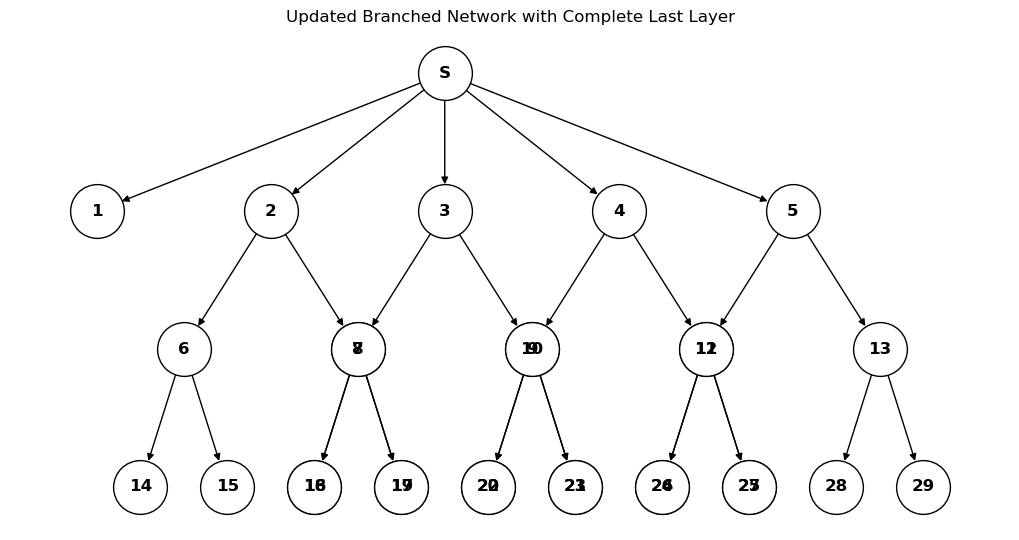

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def create_branched_network():
    G = nx.DiGraph()  # Directed graph for hierarchy
    
    # Define edges based on the updated structure with additional nodes in the last layer
    edges = [
        ('S', '1'), ('S', '2'), ('S', '3'), ('S', '4'), ('S', '5'),
        ('2', '6'), ('2', '7'), ('3', '8'), ('3', '9'), ('4', '10'), ('4', '11'),
        ('5', '12'), ('5', '13'),
        ('6', '14'), ('6', '15'), ('7', '16'), ('7', '17'),
        ('8', '18'), ('8', '19'), ('9', '20'), ('9', '21'),
        ('10', '22'), ('10', '23'), ('11', '24'), ('11', '25'),
        ('12', '26'), ('12', '27'), ('13', '28'), ('13', '29')
    ]
    
    G.add_edges_from(edges)
    return G

def draw_branched_network(G):
    plt.figure(figsize=(10, 5))
    
    # Manually define positions to maintain tree structure and avoid crossing edges
    pos = {
        'S': (0, 4),
        '1': (-2, 3), '2': (-1, 3), '3': (0, 3), '4': (1, 3), '5': (2, 3),
        '6': (-1.5, 2), '7': (-0.5, 2), '8': (-0.5, 2), '9': (0.5, 2),
        '10': (0.5, 2), '11': (1.5, 2), '12': (1.5, 2), '13': (2.5, 2),
        '14': (-1.75, 1), '15': (-1.25, 1), '16': (-0.75, 1), '17': (-0.25, 1),
        '18': (-0.75, 1), '19': (-0.25, 1), '20': (0.25, 1), '21': (0.75, 1),
        '22': (0.25, 1), '23': (0.75, 1), '24': (1.25, 1), '25': (1.75, 1),
        '26': (1.25, 1), '27': (1.75, 1), '28': (2.25, 1), '29': (2.75, 1)
    }
    
    nx.draw(G, pos, with_labels=True, node_color='white', edge_color='black', 
            node_size=1500, font_size=12, font_weight='bold', linewidths=1, 
            edgecolors='black', arrows=True)
    
    plt.title("Updated Branched Network with Complete Last Layer")
    plt.show()

if __name__ == "__main__":
    G = create_branched_network()
    draw_branched_network(G)

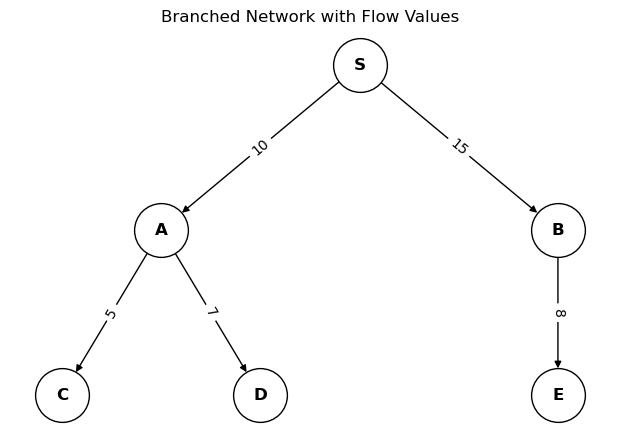

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def create_branched_network():
    G = nx.DiGraph()  # Directed graph for hierarchy
    
    # Define edges with flow values
    edges = [
        ('S', 'A', 10), ('S', 'B', 15), ('A', 'C', 5), ('A', 'D', 7), ('B', 'E', 8)
    ]
    
    for u, v, flow in edges:
        G.add_edge(u, v, flow=flow)
    
    return G

def draw_branched_network(G):
    plt.figure(figsize=(6, 4))
    
    # Define positions for clear visualization
    pos = {
        'S': (0, 3), 'A': (-1, 2), 'B': (1, 2), 'C': (-1.5, 1), 'D': (-0.5, 1), 'E': (1, 1)
    }
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='white', edge_color='black', 
            node_size=1500, font_size=12, font_weight='bold', linewidths=1, 
            edgecolors='black', arrows=True)
    
    # Draw edge labels (flow values)
    edge_labels = {(u, v): f"{d['flow']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title("Branched Network with Flow Values")
    plt.show()

if __name__ == "__main__":
    G = create_branched_network()
    draw_branched_network(G)
